## Feature selection

### Recursive feature selection with cross validation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#### Clean and transform the data

In [2]:
data = pd.read_csv('cl_Direct_Marketing.csv')
data.head()

,Age,Job,Marital Status,Education,Default,Balance,Housing Loan,Personal Loan,Last Contact Duration,Subscription
0,58,management,married,tertiary,no,2143,yes,no,261,no
1,44,technician,single,secondary,no,29,yes,no,151,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,76,no
3,47,blue-collar,married,unknown,no,1506,yes,no,92,no
4,33,unknown,single,unknown,no,1,no,no,198,no


In [3]:
# Default column - convert 'no' to 0 and 'yes' to 1
# Housing Loan column - convert 'no' to 0 and 'yes' to 1
# Personal Loan column - convert 'no' to 0 and 'yes' to 1
# Subscription column - convert 'no' to 0 and 'yes' to 1
mapper = {'no': 0, 'yes': 1}
data['Default'].replace(mapper, inplace=True)
data['Housing Loan'].replace(mapper, inplace=True)
data['Personal Loan'].replace(mapper, inplace=True)
data['Subscription'].replace(mapper, inplace=True)

In [4]:
# Create dummy columns from the categorical columns
data = pd.get_dummies(data,columns=['Job','Marital Status','Education'], drop_first=False)
data.head()

,Age,Default,Balance,Housing Loan,Personal Loan,Last Contact Duration,Subscription,Job_admin.,Job_blue-collar,Job_entrepreneur,...,Job_technician,Job_unemployed,Job_unknown,Marital Status_divorced,Marital Status_married,Marital Status_single,Education_primary,Education_secondary,Education_tertiary,Education_unknown
0,58,0,2143,1,0,261,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,44,0,29,1,0,151,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,33,0,2,1,1,76,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,47,0,1506,1,0,92,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,33,0,1,0,0,198,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [5]:
data.columns

Index(['Age', 'Default', 'Balance', 'Housing Loan', 'Personal Loan',
       'Last Contact Duration', 'Subscription', 'Job_admin.',
       'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Job_unemployed', 'Job_unknown',
       'Marital Status_divorced', 'Marital Status_married',
       'Marital Status_single', 'Education_primary', 'Education_secondary',
       'Education_tertiary', 'Education_unknown'],
      dtype='object')

In [6]:
correlated_features = set()
correlation_matrix = data.drop('Subscription', axis=1).corr()

corr_threshold = 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > corr_threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#### Remove correlated features

In [7]:
correlated_features

set()

In [8]:
### data = data.drop(correlated_features,axis=1)

#### Run recursive feature selection with cross validation (RFECV)

In [9]:
# all features (independent variables)
X = data.drop('Subscription', axis=1)

# target (dependent variable)
target = data['Subscription']

In [10]:
# estimator
rfc = RandomForestClassifier(random_state=101)

In [11]:
# RFECV
# step - number of features to remove at each iteration
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=101), scoring='accuracy')

In [12]:
# optimal number of features
rfecv.n_features_

9

In [13]:
# least important features (drop)
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 1  4  6  8  9 11 12 13 14 15 16 17 18 21 23 24]


In [14]:
# feature importance
rfecv.estimator_.feature_importances_

array([0.14816535, 0.20076297, 0.08579245, 0.49228195, 0.01606312,
       0.01250693, 0.01440887, 0.01497711, 0.01504125])

In [15]:
df = pd.DataFrame()
df['attr'] = X.columns
df['importance'] = rfecv.estimator_.feature_importances_

df = df.sort_values(by='importance', ascending=False)

In [16]:
df

,attr,importance
3,Last Contact Duration,0.492282
1,Balance,0.200763
0,Age,0.148165
2,Housing Loan,0.085792
4,Job_blue-collar,0.016063
8,Education_secondary,0.015041
7,Marital Status_single,0.014977
6,Marital Status_married,0.014409
5,Job_management,0.012507


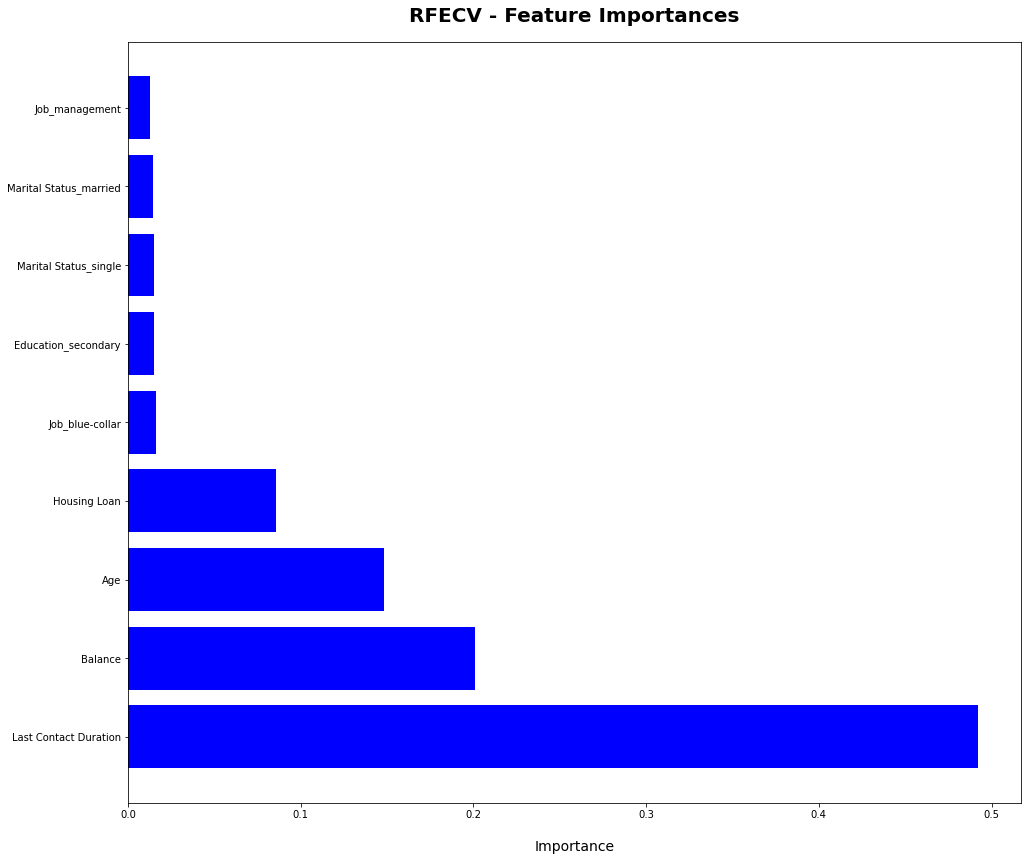

In [17]:
plt.figure(figsize=(16, 14))
plt.barh(y=df['attr'], width=df['importance'], color='blue')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()